## IMPORTING LIBRARIES

In [11]:
import itertools as it
from collections import defaultdict
import numpy as np
import urllib
import time
import matplotlib.pyplot as plt

In [50]:
import sys

num = 0
num |= (1 << 14284)

print(f"bits: {sys.getsizeof(num)*8}")
print(num)

bits: 15456
8174441013209442250384965122051947477653140974685146757738214546096354730198431312184343583006799498146823135484275167688178713912021199069807177606745579917063902792272396578425391251168892744749455115833569003505412036442032447113808151398683072488988864662913609653045366592527512456158724352755911887449890939755538862044580453288672798405678948990272934040355558529876221845859440197331597361651631176287913184096101291425482768159349655898482519341283312600123150784871828088614733033521959431785345695797070768644023592340397716779474466743925942825382826279204859970150982583529714618113116764164617284817415061906520715000305130170585599077109019488574698035621379927328672707222041503040206336136796279707322591301180678919801558829645417037792167254488749464710054492815773165352783191865690140355572834472401450273813205611607220550435197969792466515690879043501299956350800171521326487487845494445156443974468003309523801634728078446681747276676560082593983814678317702523655

## LOADING DATA

In [12]:
# Load the retail dataset from the URL, this will be used in lab 4, not lab 3
def load_data_from_url(url):
    response = urllib.request.urlopen(url)
    lines = response.readlines()
    dataset = [list(map(int, line.strip().split())) for line in lines]
    return dataset

dataset = load_data_from_url("http://fimi.uantwerpen.be/data/retail.dat")

## APRIORI ALGORITHM

In [13]:
def apriori(dataset, min_support) -> list:
    frequent_sets = []

    # Pass 1: recording singleton support in dictionary
    # This generates C1
    C1 = defaultdict(int)
    for basket in dataset:
        for item in basket:
            C1[item] += 1
    
    
    # Pruning C1: removing infrequent singletons from dictionary
    # this generates L1
    items = tuple(C1)
    # if the item count is less than support, entry is removed from dictionary
    for item in items:
        if C1[item] < min_support:
            del C1[item]
    # defining frequent itemset map as L1
    L1 = C1
    # appending list of frequent singletons to frequent_sets
    for i in L1:
        frequent_sets.append(i)
    
    
    # Generating candidate item pairs for C2 using singletons in L1
    pairs = it.combinations(L1,2)
    # initializing C2 with candidates
    C2 = {}
    for pair in pairs:
        C2[tuple(sorted(pair))] = 0


    # Pass 2: finding support of all candidate item pairs in C2
    for basket in dataset:
        for pair in it.combinations(basket,2):
            pair = tuple(sorted(pair))
            if pair in C2:
                C2[pair] += 1

    
    # Pruning: removing all infrequent item pairs from C2
    # this will generate L2
    pairs = tuple(C2)
    for pair in pairs:
        pair = tuple(sorted(pair))
        if C2[pair] < min_support:
            del C2[pair]
    L2 = C2
    # appending list of frequent pairs to frequent_sets
    for i in L2:
        frequent_sets.append(i)
    
    return frequent_sets

## BUCKET HASHING FUNCTION

In [14]:
# Hash function for PCY algorithm, do not modify this, should be used in the pcy_algorithm function
def hash_function(pair, num_buckets):
    i, j = pair
    hash_value = ((i * num_buckets) + j) % num_buckets
    return hash_value

## PCY ALGORITHM

In [15]:
def pcy_algorithm(dataset, min_support, hash_buckets) -> list:
    
    frequent_items = []

    # Pass 1: counting singletons and hashing pairs to buckets
    # each pair will be sorted in order to maintain consistent hashing for out of order pairs
    C1 = defaultdict(int)
    buckets = defaultdict(int)

    for basket in dataset:
        
        for i in basket:
            C1[i] += 1
            
        for p in it.combinations(basket,2):
            buckets[hash_function(sorted(p),hash_buckets)] += 1
    
    
    
    # Pruning C1 to create L1 for singletons
    # converting buckets to a bit-vector
    items = tuple(C1)
    
    for i in items:
        if C1[i] < min_support:
            del C1[i]
    
    # L1 is mapping of frequent singletons
    L1 = C1
    for i in L1:
        frequent_items.append(i)

    # converting buckets to a bit vector
    bitvector = 0
    for x in buckets:
        if(buckets[x] >= min_support):
            bitvector |= (1 << x)
            
    # delete redundant hashmap
    del buckets
    
    # Pass 2: Generating C2 using L1 and bit vector to reduce candidate pair list
    C2 = defaultdict(int)
    
    for basket in dataset:
    
        for p in it.combinations(basket,2):
    
            p = tuple(sorted(p))
            bucket_num = hash_function(p, hash_buckets)
    
            if( (p[0] in L1) and (p[1] in L1) and (bitvector & (1 << bucket_num))):
                C2[p] += 1
                
                
                
    # pruning infrequent item pairs
    pairs = tuple(C2)
    
    for p in pairs:
        if C2[p] < min_support:
            del C2[p]
    
    L2 = C2
    for p in L2:
        frequent_items.append(p)
    


    return frequent_items

## COMPARING RUNTIMES

In [16]:
# generating a sequence of partitions of the dataset
# each partition is from the oth to nth basket
partitions = [0, 100, 500, 2000, 5000]

# this is the total number of bits that can be stored in a single integer
NUM_BUCKETS = 14285 

# data points for graphing
x = [] # number of baskets
ap_y = [] # apriori runtime per basket
pcy_y = [] # pcy runtime per basket

for E in partitions:
    
    # extracting current dataset partition
    d = dataset[:E]
    support = 5
    
    ### RUNTIME OF APRIORI ###
    ap_start = time.time()
    apriori_freq_items = apriori(d, support)
    ap_end = time.time()
    
    ### RUNTIME OF PCY ###
    pcy_start = time.time()
    pcy_freq_items = pcy_algorithm(d, support, NUM_BUCKETS)
    pcy_end = time.time()
    
    x.append(E)
    ap_y.append((ap_end-ap_start)*1000)
    pcy_y.append((pcy_end-pcy_start)*1000)    
        

## PLOTTING DATA

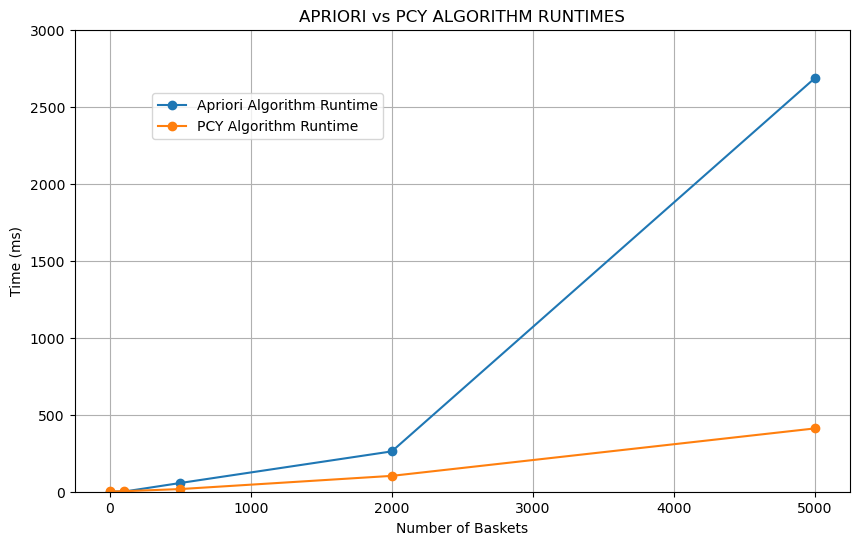

In [17]:
# Create a figure with 1 subplots
fig, ax = plt.subplots(figsize=(10,6))
# Plotting apriori runtimes
ax.plot(x, ap_y, '-o', label='Apriori Algorithm Runtime')
# Plotting pcy runtimes
ax.plot(x, pcy_y, '-o', label='PCY Algorithm Runtime')


# Adding labels and a title
ax.set_xlabel('Number of Baskets')
ax.set_ylabel('Time (ms)')
ax.set_title('APRIORI vs PCY ALGORITHM RUNTIMES')
ax.grid()
ax.set_ylim(0,max(pcy_y))
ax.set_yticks( range(0,round(max(pcy_y)+3000),500) )
ax.legend(loc=(0.1,0.763))

plt.show()

#### USE THIS  ltuple SUBLCASS INSTEAD OF FROZENSET SUBCLASS

In [18]:
import sys
class ltuple(tuple):
    def __repr__(self):
        return str(list(self))


#### 10 million buckets seems to be a good balanace between sufficient size and computation time

In [19]:
import numpy as np
array = np.zeros((10000000,))

print(sys.getsizeof(array)/(2**30))
for i in range(len(array)):
    array[i] = i    

0.07450591027736664
